Problem Statement: Optimizing E-commerce Performance and Customer Understanding  (our data only has 49k rows on avg so we dont need to use a sample. we use a sample when we got millions or billions of rows)
The goal is to leverage the provided e-commerce transaction data to gain actionable insights for improving business performance. This includes understanding customer behavior, optimizing sales and marketing strategies, and potentially improving operational efficiency like inventory management or identifying areas for cost reduction



In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score    

df= pd.read_csv(r"C:\Users\risha\Desktop\capstone project\Python eda hypothesis\ecomm\online_sales_dataset.csv")


df.head(5)                                 # statistical summary of numerical columns
print(df.duplicated().sum())             #no duplicate values found
df.isnull().sum()                         #  null values found

df.dropna(subset=['CustomerID'],inplace=True)                   # dropping null values of customer id 
df['ShippingCost'].fillna(df['ShippingCost'].median(), inplace=True)  #let's use the median to impute as it's less sensitive to outliers.
df['WarehouseLocation'].fillna(df['WarehouseLocation'].mode()[0], inplace=True)  #filling null values with mode as it is categorical column
df = df[df['Quantity'] > 0]          # Remove transactions with negative or zero Quantity (returns/cancellations or data entry errors)
df = df[df['UnitPrice'] > 0]     # Remove items with zero or negative UnitPrice
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors= 'coerce')  #converting invoice date to datetime format
df.dropna()
df.info()
print(df.describe())

0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 44804 entries, 0 to 49781
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   InvoiceNo          44804 non-null  int64         
 1   StockCode          44804 non-null  object        
 2   Description        44804 non-null  object        
 3   Quantity           44804 non-null  int64         
 4   InvoiceDate        44804 non-null  datetime64[ns]
 5   UnitPrice          44804 non-null  float64       
 6   CustomerID         44804 non-null  float64       
 7   Country            44804 non-null  object        
 8   Discount           44804 non-null  float64       
 9   PaymentMethod      44804 non-null  object        
 10  ShippingCost       44804 non-null  float64       
 11  Category           44804 non-null  object        
 12  SalesChannel       44804 non-null  object        
 13  ReturnStatus       44804 non-null  object        
 14  Ship

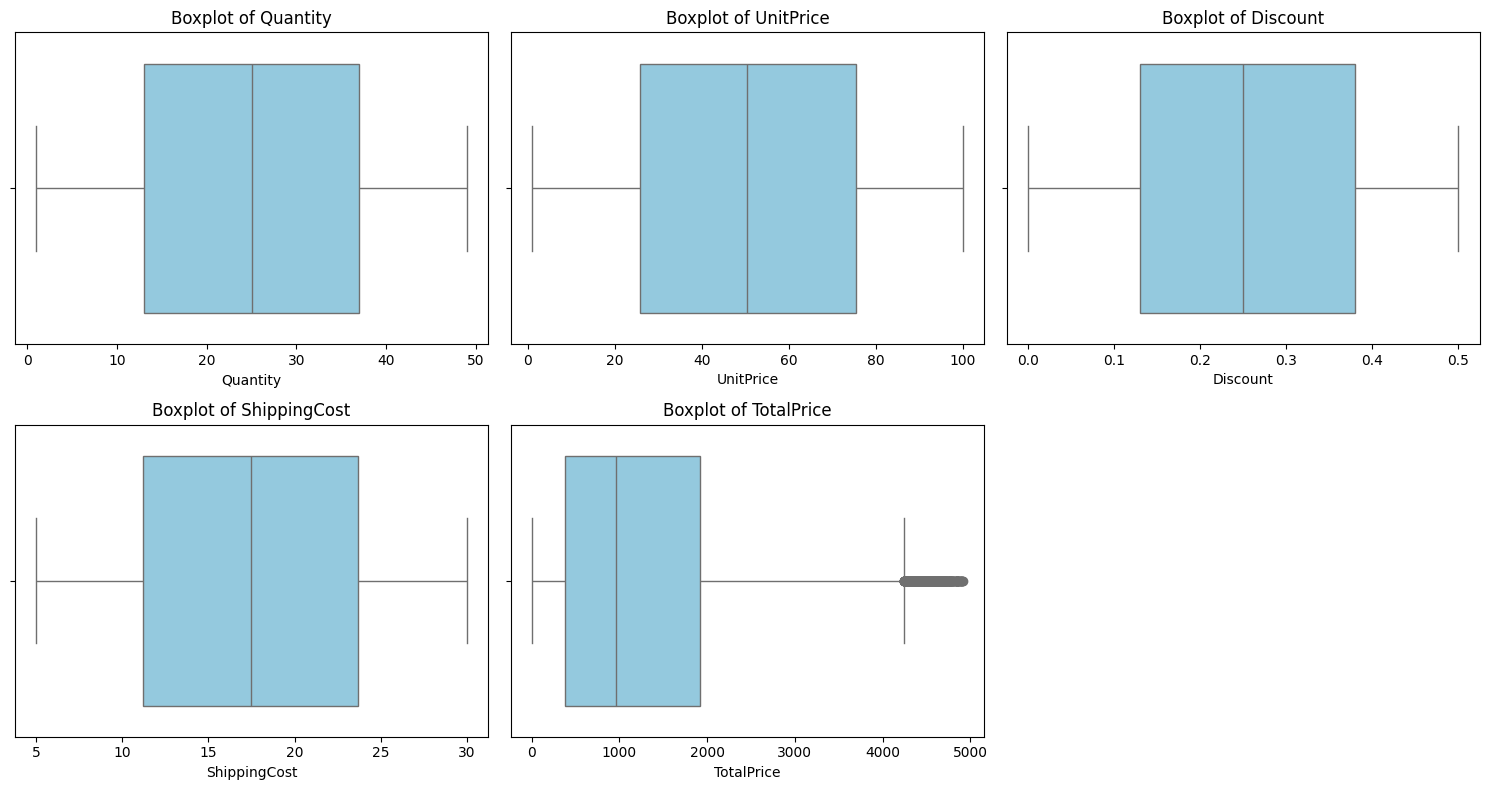

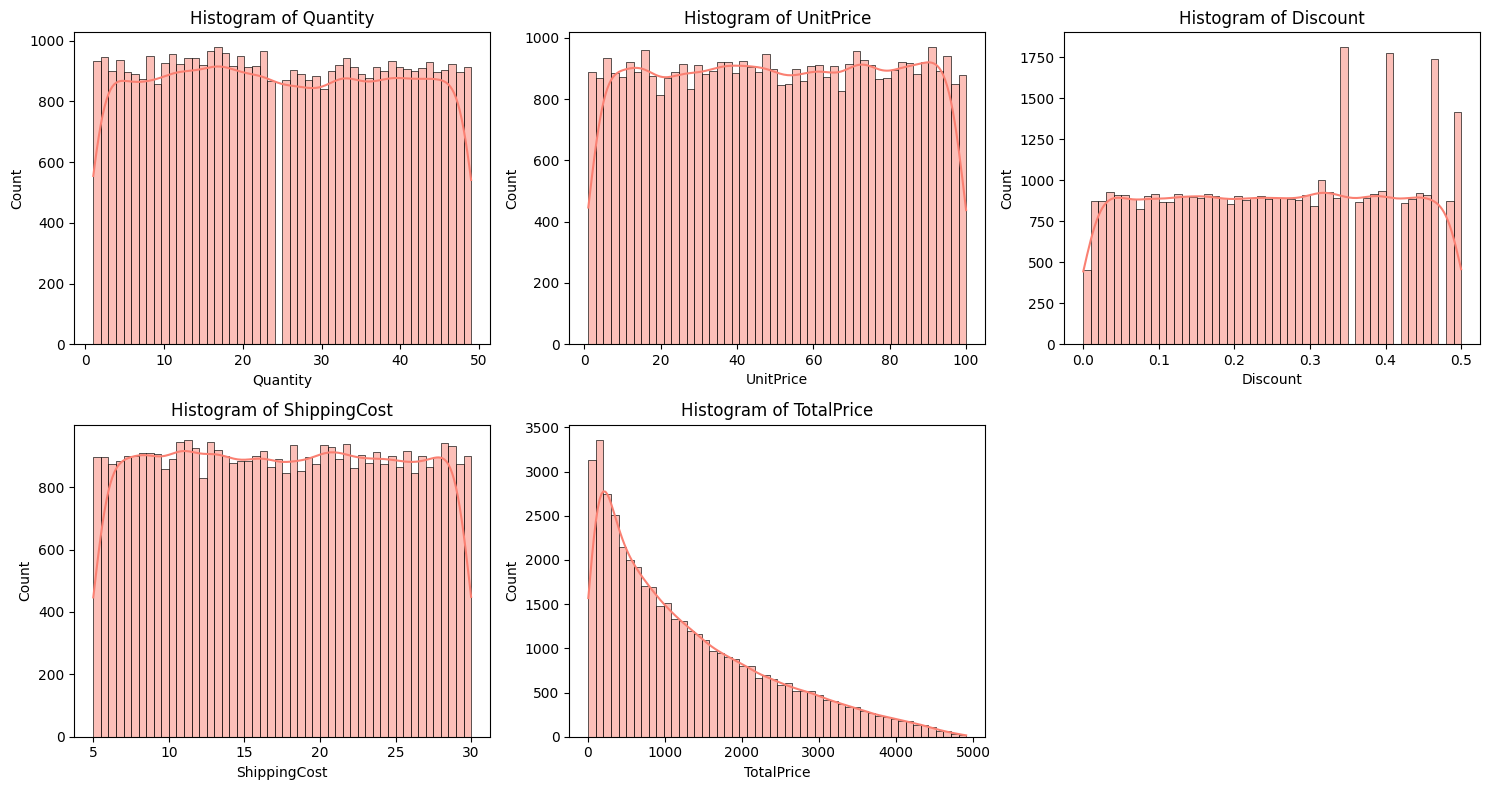

In [2]:

# Derive TotalPrice
df["TotalPrice"] = (df["Quantity"] * df["UnitPrice"]) - df["Discount"] + df["ShippingCost"]

# Columns to check
cols = ["Quantity", "UnitPrice", "Discount", "ShippingCost", "TotalPrice"]


# Boxplots for Outlier Detection

plt.figure(figsize=(15, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

# ---------------------------
# Histograms for Distribution
# ---------------------------
plt.figure(figsize=(15, 8))
for i, col in enumerate(cols, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=50, kde=True, color="salmon")
    plt.title(f"Histogram of {col}")
plt.tight_layout()
plt.show()


In [3]:
#since outliers are only in found in TotalPrice. lets find them

Q1 = df['TotalPrice'].quantile(0.25)
Q3 = df['TotalPrice'].quantile(0.75)    
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
outliers = df[(df['TotalPrice'] < lower_bound) | (df['TotalPrice'] > upper_bound)]
print(f"Number of outliers in TotalPrice: {outliers.shape[0]}") 


print("""
There are 533 outlier values out of 44,804 rows (1.2%). Given the large dataset size, these outliers are unlikely to significantly affect the overall analysis.

The outliers are consistent with expected behavior, such as large orders or premium products.A histogram of the data shows a smooth tapering, rather than abrupt spikes, which suggests that these are legitimate data points rather
than errors.

Additionally, there is no evidence of anomalies in the input variables (e.g., unusually high prices,quantities, or discounts). In real business data, especially in B2B or bulk retail scenarios, 
it's common to see some customers placing large orders.
""")


Lower Bound: -1941.6462500000007, Upper Bound: 4239.563750000001
Number of outliers in TotalPrice: 533

There are 533 outlier values out of 44,804 rows (1.2%). Given the large dataset size, these outliers are unlikely to significantly affect the overall analysis.

The outliers are consistent with expected behavior, such as large orders or premium products.A histogram of the data shows a smooth tapering, rather than abrupt spikes, which suggests that these are legitimate data points rather
than errors.

Additionally, there is no evidence of anomalies in the input variables (e.g., unusually high prices,quantities, or discounts). In real business data, especially in B2B or bulk retail scenarios, 
it's common to see some customers placing large orders.



Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Discount', 'PaymentMethod',
       'ShippingCost', 'Category', 'SalesChannel', 'ReturnStatus',
       'ShipmentProvider', 'WarehouseLocation', 'OrderPriority', 'TotalPrice',
       'LogTotalPrice'],
      dtype='object')

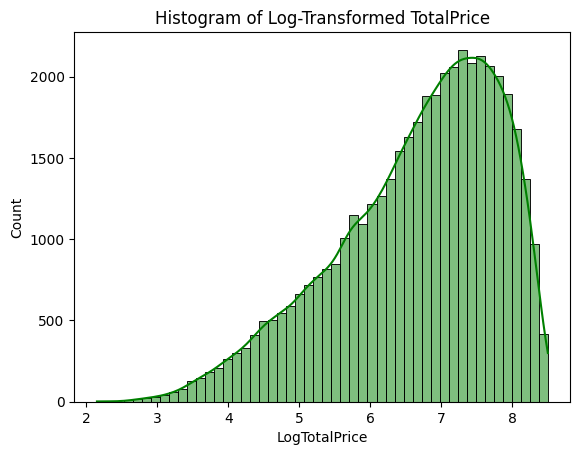

In [4]:
df['LogTotalPrice'] = np.log1p(df['TotalPrice'])                                    # Log-transform TotalPrice to reduce skewness and just for visualziations we're gonnna use this nothing else.
sns.histplot(df['LogTotalPrice'], bins=50, kde=True, color="green")
plt.title("Histogram of Log-Transformed TotalPrice")
df.columns

In [5]:
#Just for calcuating sample size. we  are not using this as 44.8k rows is good enough for analysis. if we had millions of rows then we would have used this.
Z = 1.96  # Z-value for 95% confidence
sigma = 0.144349  # Population standard deviation
E = 0.01  # Margin of error

# Sample size formula
n = (Z * sigma / E) ** 2
print(f"Sample size: {n}")

sample_df = df.sample(n=800, random_state=42).reset_index(drop=True)  # Reset index and drop old index
print(sample_df.shape)  # Get the shape of the sampled dataframe
sample_df.describe()


Sample size: 800.4601240992158
(800, 19)


,InvoiceNo,Quantity,UnitPrice,CustomerID,Discount,ShippingCost,TotalPrice,LogTotalPrice
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,571321.177500,24.926250,49.664950,53693.956250,0.244263,17.442013,1256.449788,6.676287
std,260504.194276,13.641331,28.208422,25596.216145,0.146497,7.253231,1062.233330,1.088857
min,100318.000000,1.000000,1.180000,10153.000000,0.000000,5.040000,17.820000,2.934920
25%,340606.500000,14.000000,24.757500,32613.500000,0.110000,11.117500,380.775000,5.944824
50%,591432.500000,24.000000,50.515000,52361.000000,0.240000,17.415000,886.690000,6.788604
75%,795236.250000,37.000000,72.855000,75732.750000,0.370000,23.602500,1945.505000,7.573788
max,999482.000000,49.000000,99.880000,99728.000000,0.500000,29.970000,4723.230000,8.460460


“Since the dataset is only ~45k rows, we used the full data for analysis instead of sampling. Power analysis confirmed that even a sample of ~800 rows would have been statistically sufficient, but using the complete dataset improves accuracy and avoids information loss.”

----------A/B tests -------------------------------------------------------------------------------------------------------------------------------------------------------------------------

1)Impact of Discounts on Sales (A/B Test - t-test)
Null Hypothesis (H₀): There is no significant difference in mean TotalPrice between orders with discounts and those without.
Alternative Hypothesis (H₁): Orders with discounts have a significantly different mean TotalPrice than orders without.

Metric: TotalPrice (primary), Quantity (secondary).

In [6]:
discounted = df.loc[df['Discount'] > 0, 'TotalPrice']
no_discount = df.loc[df['Discount'] == 0, 'TotalPrice']


# A/B Test - t-test
t_stat, p_value = ttest_ind(discounted, no_discount)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("Reject H₀: There is a significant difference in mean TotalPrice between the groups.")
else:
    print("Fail to reject H₀: There is no significant difference in mean TotalPrice.")

T-statistic: -1.4367675074420896, P-value: 0.1507910488192188
Fail to reject H₀: There is no significant difference in mean TotalPrice.


Since p > 0.05 → no statistically significant impact of discounts on order value.  
  Business insight: Discounts might not be driving revenue the way management expects.

2)Payment Method and Order Value (ANOVA)- comparing the average TotalPrice across multiple payment methods.
Group by PaymentMethod (e.g., Credit Card, PayPal, Cash).Run an ANOVA to see if the mean TotalPrice differs significantly between the groups.

Hypotheses:
H₀: Average TotalPrice is the same across all PaymentMethod groups.                       H₁: At least one PaymentMethod group has a significantly different average TotalPrice.

In [7]:
from scipy.stats import f_oneway

# Group by PaymentMethod and calculate TotalPrice for each group
groups = [
    df.loc[df['PaymentMethod'] == method, 'TotalPrice'] 
    for method in df['PaymentMethod'].unique()
]


# Perform ANOVA
f_stat, p_value = f_oneway(*groups)

print(f"F-statistic: {f_stat}, P-value: {p_value}")

# Check if p-value is below significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject H₀: There is a significant difference in average TotalPrice across PaymentMethods.")
else:
    print("Fail to reject H₀: There is no significant difference in average TotalPrice.")


F-statistic: 0.7188274384592874, P-value: 0.4873289581525797
Fail to reject H₀: There is no significant difference in average TotalPrice.


Since p > 0.05 → payment choice doesn’t affect order size significantly.                                    
Business insight: Customers spend similarly regardless of payment method (good to know for ops/finance).

3)Category vs. Return Behavior (Chi-Square Test)-  whether there's a relationship between product category and return status (i.e., whether certain categories have higher return rates).
Create a contingency table of Category vs. ReturnStatus. Run the Chi-Square test to see if there's a significant relationship between these two categorical variables.

Hypotheses:

H₀: Category and ReturnStatus are independent (no relationship).              H₁: Certain Categories are associated with higher/lower return rates.

In [8]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['Category'], df['ReturnStatus'])

# Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared statistic: {chi2_stat}, P-value: {p_value}")

# Check if p-value is below significance level (e.g., 0.05)
if p_value < 0.05:
    print("Reject H₀: There is a significant relationship between Category and ReturnStatus.")
else:
    print("Fail to reject H₀: There is no significant relationship between Category and ReturnStatus.")


Chi-squared statistic: 1.1411603380287418, P-value: 0.8876878806668211
Fail to reject H₀: There is no significant relationship between Category and ReturnStatus.


Since p > 0.05 → no significant link between product category and return rate.
Business insight: Returns are spread evenly across categories, so no one product type is riskier.

Regression model to predict TotalPrice of an order based on transaction-level features.
Dependent variable (y): TotalPrice_winsorized (capped version for stability).        
Independent variables (X):
Numeric: Quantity, Discount, ShippingCost, UnitPrice.
Categorical: PaymentMethod, Category, SalesChannel, OrderPriority (encode them).

R²: 0.8627642314894717
RMSE: 397.80603872530486


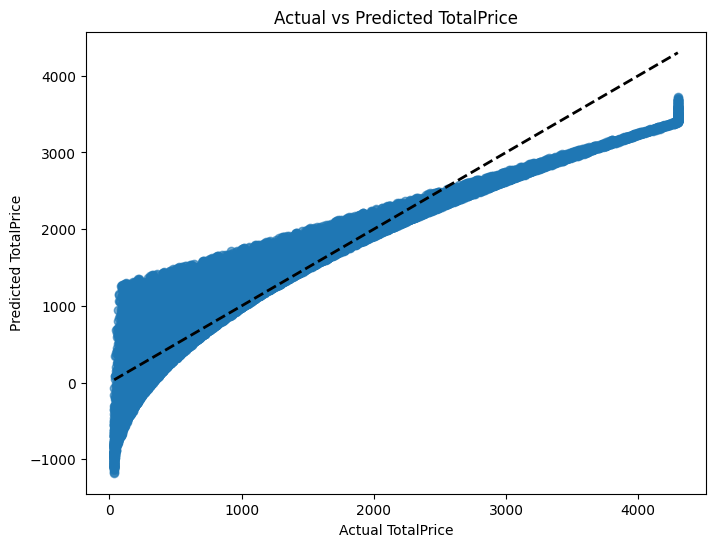

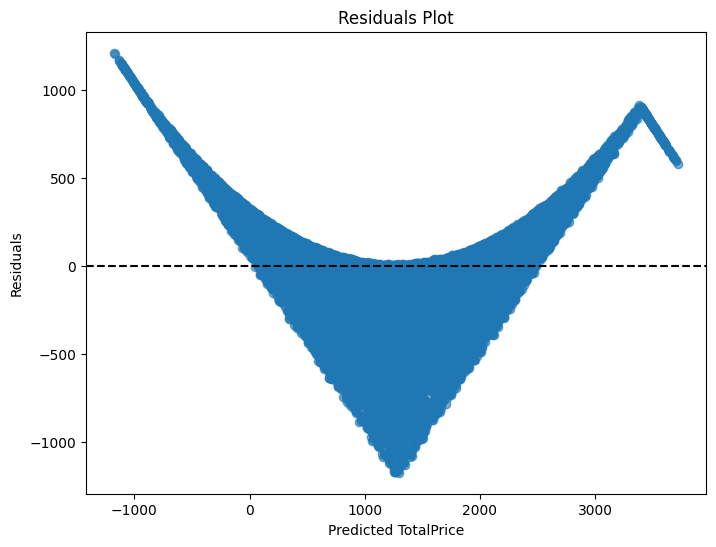

In [ ]:
#Regression models are sensitive to outliers → a few very large orders could dominate the fit.That can lead to inflated coefficients and lower interpretability.
# Calculate the lower and upper quantiles (1st and 99th percentiles)
lower_bound = df["TotalPrice"].quantile(0.01)                                                               
upper_bound = df["TotalPrice"].quantile(0.99)

# Identify outliers based on the bounds
outliers = df[(df['TotalPrice'] < lower_bound) | (df['TotalPrice'] > upper_bound)]

# Create a new column with Winsorized values of TotalPrice
df["TotalPrice_winsorized"] = df["TotalPrice"].clip(lower=lower_bound, upper=upper_bound)   #clip() replaces values that are below a lower threshold with the lower threshold value, and values that are above an upper threshold with the upper threshold value.

# One-hot encode categorical features
df_encoded = pd.get_dummies(df[["Quantity", "UnitPrice", "Discount", "ShippingCost",        #get_dummies is used to convert categorical variable into numeric format so that it can be used in regression model
                                "PaymentMethod", "Category", "SalesChannel"]], drop_first=True)

X = df_encoded
y = df["TotalPrice_winsorized"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))



# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for perfect prediction
plt.xlabel('Actual TotalPrice')
plt.ylabel('Predicted TotalPrice')
plt.title('Actual vs Predicted TotalPrice')
plt.show()


# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='black', linestyle='--')  # Line at 0 for reference
plt.xlabel('Predicted TotalPrice')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()


1. Residuals Plot:
The U-shaped pattern you see in the residuals plot suggests that the residuals are not randomly distributed around zero. This typically indicates that the linear regression model might not be capturing some non-linear relationships in the data. A well-fitted linear regression model would have residuals randomly scattered around zero without any clear pattern.
This pattern suggests that a non-linear model (e.g., polynomial regression, decision trees, etc.) might provide a better fit for the data.
for small orders the model fits well, but for large orders, errors blow up.


2. Actual vs Predicted Plot:

The plot shows a clear trend where predicted values increase as the actual values increase. However, there is a noticeable spread at higher values, particularly around the higher predicted values, indicating that the model might be over-predicting at the higher end (this is suggested by the upper tail curving upward more steeply).
This again could point to the model struggling to fit the data at higher levels and possibly overfitting or underfitting in certain ranges.

Ideally: points should be close to the diagonal 45° line (perfect prediction).
 plot shows:
Model underpredicts high-value orders (predicted line flattens below diagonal).
Model overpredicts some low-value orders (points above line near 0).
This is exactly what happens when:
Outliers / skew dominate → linear regression can’t capture extreme values well.
Model assumes a strictly linear relationship, but the data is more complex.

“We built a multiple linear regression model to predict transaction-level revenue (TotalPrice). The model achieved an R² of 0.86 and RMSE of ~398, indicating strong predictive power. Quantity and UnitPrice were the most significant drivers of revenue, while discount reduced revenue as expected. This analysis provides actionable insights into the key levers of order value.”
“The regression model predicts the majority of transactions well, but struggles with bulk/high-value orders. This suggests different dynamics may drive large corporate purchases vs. regular consumer orders.”

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

applying a polynomial regression model (degree 2) 
y=β0​+(β1​)x+(β2​)x^2   
look like a non-linear relationship in terms of the original features because we're including terms like x^2, X^3.. etc in polynomial reggresion which curve the relationship between input and output.
But from the modeling perspective, polynomial regression is still a linear model because it’s linear in the parameters (the β coefficients).
multilinear with degree 2-
y=β0​+β1.​x1​+β2.​x2​+β3​.x1^2​+β4​x2^2​+β5.​x1*​x2​+ϵ

R² (Polynomial): 0.9993946839698757


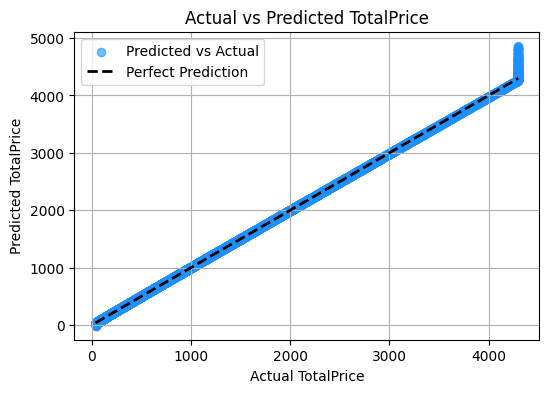

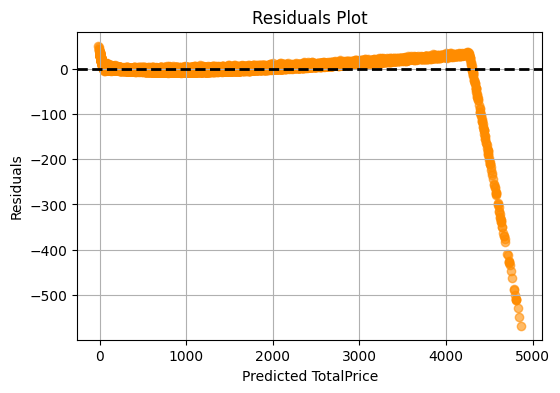

R²: 0.999
RMSE: 26.42


In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R² (Polynomial):", r2_score(y_test, y_pred))


# --- 1. Actual vs Predicted Plot ---
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_pred, alpha=0.6, color='dodgerblue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual TotalPrice')
plt.ylabel('Predicted TotalPrice')
plt.title('Actual vs Predicted TotalPrice')
plt.legend()
plt.grid(True)
plt.show()

# --- 2. Residuals Plot ---
residuals = y_test - y_pred

plt.figure(figsize=(6, 4))
plt.scatter(y_pred, residuals, alpha=0.6, color='darkorange')
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.xlabel('Predicted TotalPrice')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)
plt.show()

# --- Optional: Print Metrics ---
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")


We applied a polynomial regression model (degree 2) which significantly improved the fit (R² = 0.99, RMSE ≈ ...), compared to the baseline linear model (R² = 0.86). This suggests a strong non-linear relationship between the predictors and transaction-level revenue